In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Anomaly detection

Anomaly detection is task of detecting abnormal points, points that deviate from the normal behaviour of the general series. This is crucial in many application, such as cybersecurity or equipment monitoring.

In this tutorial, we explore in detail the anomaly detection capability of TimeGPT.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/20_anomaly_detection')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/20_anomaly_detection.ipynb)

## Import packages

First, we import the required packages for this tutorial and create an instance of `NixtlaClient`.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

::: {.callout-important}

## Use an Azure AI endpoint

To use an Azure AI endpoint, remember to also set the `base_url` argument: 

``` python
nixtla_client = NixtlaClient( 
    base_url="your azure ai endpoint", 
    api_key="my_api_key_provided_by_nixtla" 
) 
```
::: 

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## Load dataset

Now, let's load the dataset for this tutorial. We use the Peyton Manning dataset which tracks the visits to the Wikipedia page of Peyton Mannig.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/peyton_manning.csv')

df.head()

,timestamp,value
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


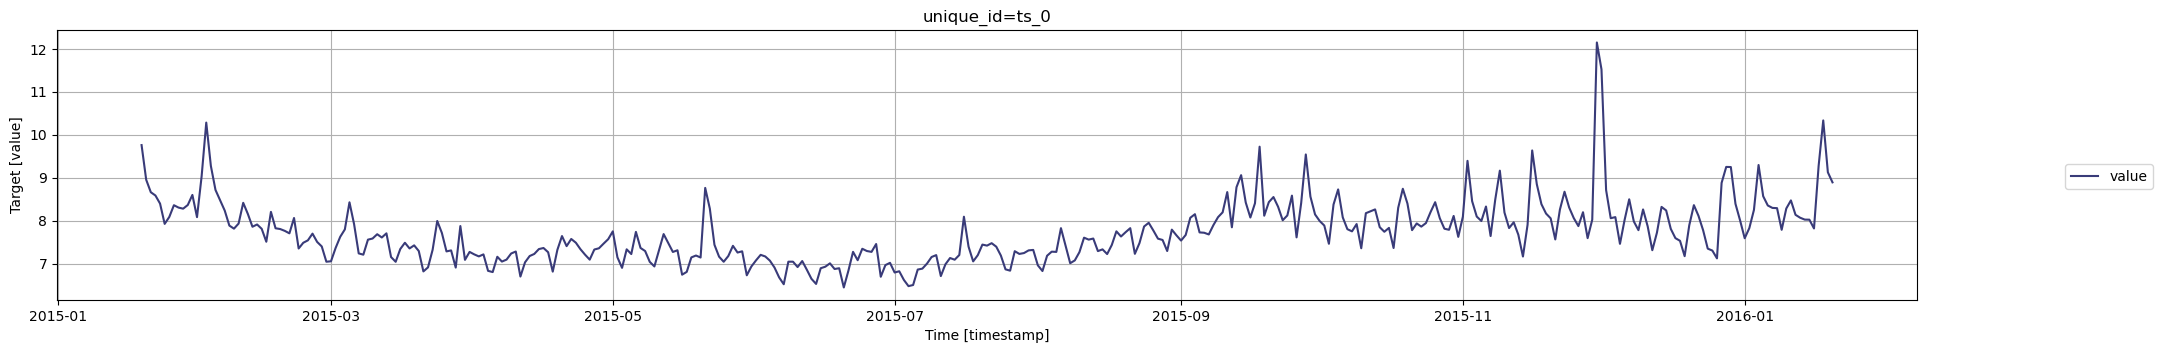

In [ ]:
nixtla_client.plot(
    df,
    time_col='timestamp',
    target_col='value',
    max_insample_length=365
)

## Anomaly detection

We now perform anomaly detection. By default, TimeGPT uses a 99% confidence interval. If a point falls outisde of that interval, it is considered to be an anomaly.

In [ ]:
anomalies_df = nixtla_client.detect_anomalies(
    df, 
    time_col='timestamp', 
    target_col='value', 
    freq='D'
)

anomalies_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


,timestamp,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
0,2008-01-10,0,6.936009,8.224194,9.512378
1,2008-01-11,0,6.863336,8.151521,9.439705
2,2008-01-12,0,6.839064,8.127249,9.415433
3,2008-01-13,0,7.629072,8.917256,10.205441
4,2008-01-14,0,7.714111,9.002295,10.290480


::: {.callout-important}

## Available models in Azure AI

If you are using an Azure AI endpoint, please be sure to set `model="azureai"`: 

``` python
nixtla_client.detect_anomalies(..., model="azureai") 
```

For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`.   By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`. 

::: 

As you can see, 0 is assigned to "normal" values, as they fall inside the confidence interval. A label of 1 is then assigned to abnormal points.

We can also plot the anomalies using `NixtlaClient`.

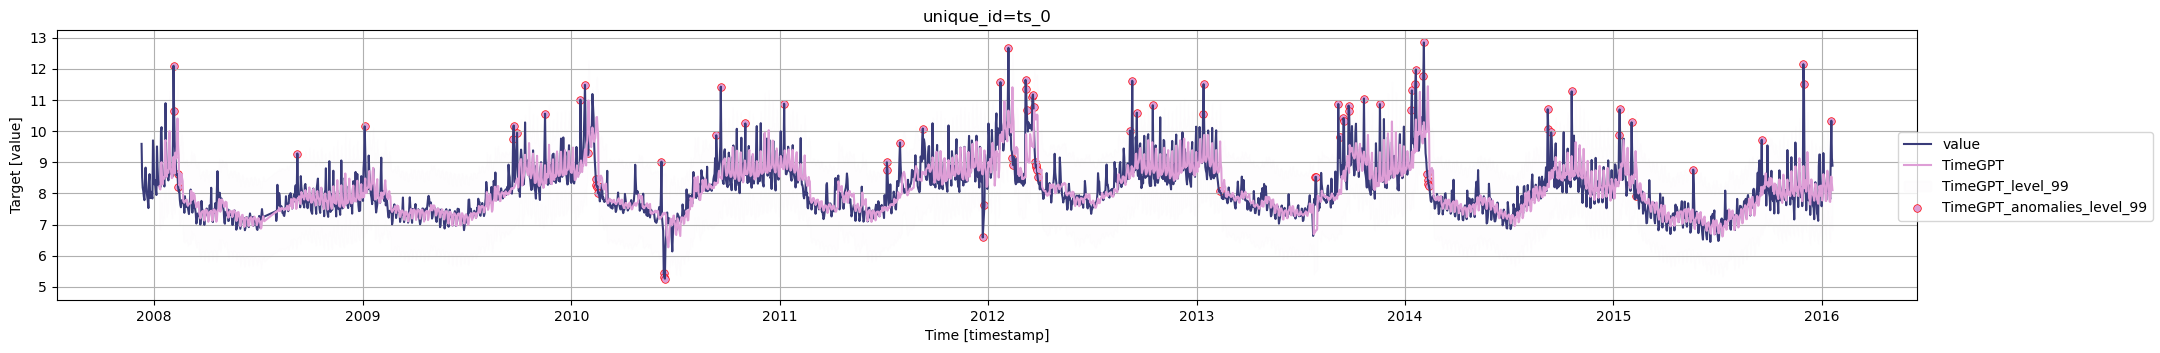

In [ ]:
nixtla_client.plot(
    df, 
    anomalies_df,
    time_col='timestamp', 
    target_col='value'
)

## Anomaly detection with exogenous features

Previously, we performed anomaly detection without using any exogenous features. Now, it is possible to create features specifically for this scnenario to inform the model in its task of anomaly detection.

Here, we create date features that can be used by the model.

This is done using the `date_features` argument. We can set it to `True` and it will generate all possible features from the given dates and frequency of the data. Alternatively, we can specify a list of features that we want. In this case, we want only features at the *month* and *year* level.

In [ ]:
anomalies_df_x = nixtla_client.detect_anomalies(
    df, time_col='timestamp', 
    target_col='value', 
    freq='D', 
    date_features=['month', 'year'],
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Using the following exogenous variables: month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12, year_2007, year_2008, year_2009, year_2010, year_2011, year_2012, year_2013, year_2014, year_2015, year_2016


Then, we can plot the weights of each feature to understand its impact on anomaly detection.

<Axes: ylabel='features'>

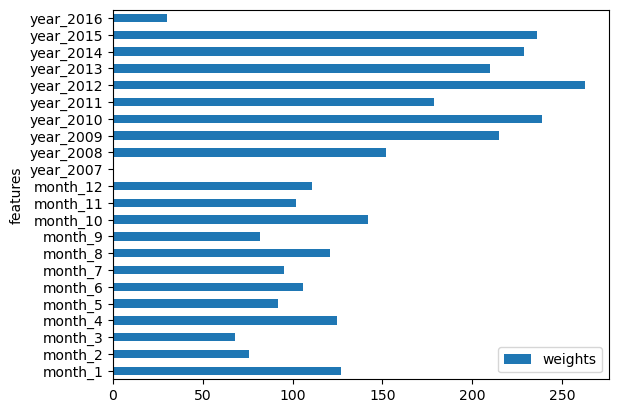

In [ ]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')

## Modifying the confidence intervals

We can tweak the confidence intervals using the `level` argument. This takes any values between 0 and 100, including decimal numbers.

Reducing the confidence interval resutls in more anomalies being detected, while increasing it will reduce the number of anomalies.

Here, for example, we reduce the interval to 70%, and we will notice more anomalies being plotted (red dots).

In [ ]:
anomalies_df = nixtla_client.detect_anomalies(
    df, 
    time_col='timestamp', 
    target_col='value', 
    freq='D',
    level=70
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


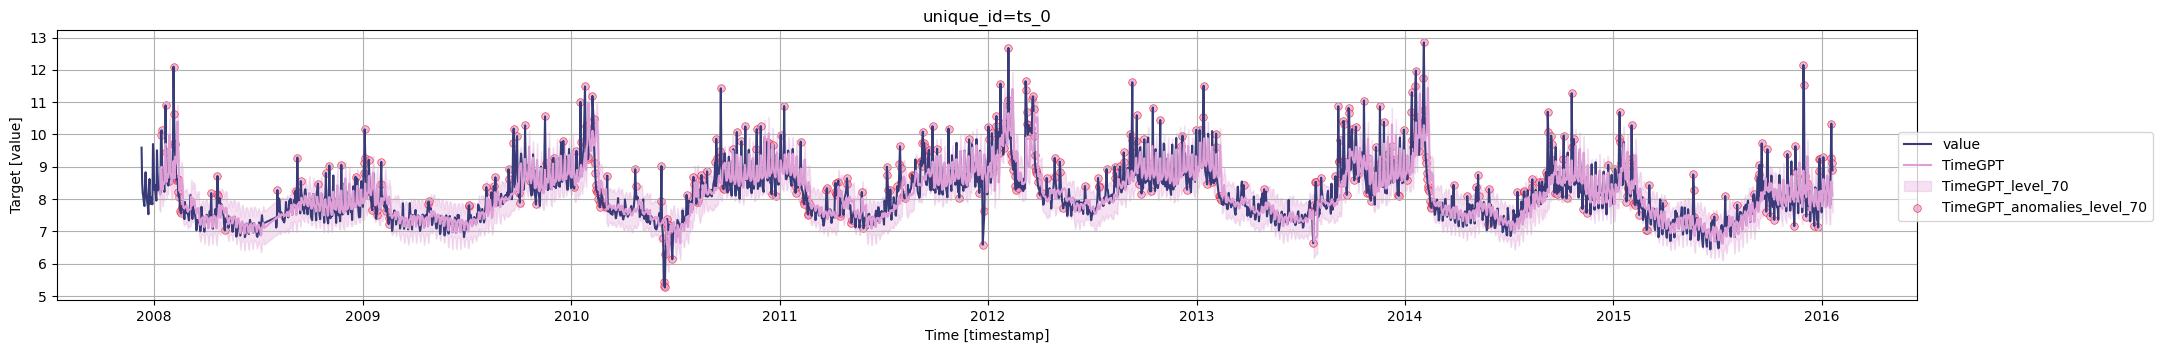

In [ ]:
nixtla_client.plot(
    df, 
    anomalies_df,
    time_col='timestamp', 
    target_col='value'
)